# Classificação de Sentimento: Reviews de E-commerce (B2W)

O objetivo central deste estudo é aplicar um fluxo completo de Processamento de Linguagem Natural (NLP) para classificar a satisfação de clientes em reviews de e-commerce. O foco metodológico consiste na **avaliação comparativa de diferentes técnicas de vetorização de texto (Bag of Words vs TF-IDF)** para identificar o modelo mais promissor na distinção entre feedbacks positivos e negativos.

### Fonte dos Dados
O conjunto de dados contém registros de avaliações reais de usuários (Americanas/Submarino) e foi obtido através do repositório oficial da B2W Digital:
* **Dataset:** [B2W-Reviews01](https://github.com/americanas-tech/b2w-reviews01)
* **Alvo (Target):** `sentimento` (Inferido a partir da coluna `overall_rating`: Positivo se nota > 3, Negativo caso contrário).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../data/raw/B2W-Reviews01.csv')
data

,submission_date,reviewer_id,product_id,product_name,product_brand,site_category_lv1,site_category_lv2,review_title,overall_rating,recommend_to_a_friend,review_text,reviewer_birth_year,reviewer_gender,reviewer_state
0,2018-01-01 00:11:28,d0fb1ca69422530334178f5c8624aa7a99da47907c44de...,132532965,Notebook Asus Vivobook Max X541NA-GO472T Intel...,NaN,Informática,Notebook,Bom,4,Yes,Estou contente com a compra entrega rápida o ú...,1958.0,F,RJ
1,2018-01-01 00:13:48,014d6dc5a10aed1ff1e6f349fb2b059a2d3de511c7538a...,22562178,Copo Acrílico Com Canudo 500ml Rocie,NaN,Utilidades Domésticas,"Copos, Taças e Canecas","Preço imbatível, ótima qualidade",4,Yes,"Por apenas R$1994.20,eu consegui comprar esse ...",1996.0,M,SC
2,2018-01-01 00:26:02,44f2c8edd93471926fff601274b8b2b5c4824e386ae4f2...,113022329,Panela de Pressão Elétrica Philips Walita Dail...,philips walita,Eletroportáteis,Panela Elétrica,ATENDE TODAS AS EXPECTATIVA.,4,Yes,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,1984.0,M,SP
3,2018-01-01 00:35:54,ce741665c1764ab2d77539e18d0e4f66dde6213c9f0863...,113851581,Betoneira Columbus - Roma Brinquedos,roma jensen,Brinquedos,Veículos de Brinquedo,presente mais que desejado,4,Yes,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,1985.0,F,SP
4,2018-01-01 01:00:28,7d7b6b18dda804a897359276cef0ca252f9932bf4b5c8e...,131788803,"Smart TV LED 43"" LG 43UJ6525 Ultra HD 4K com C...",lg,TV e Home Theater,TV,"Sem duvidas, excelente",5,Yes,"A entrega foi no prazo, as americanas estão de...",1994.0,M,MG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132368,2018-05-31 23:30:50,15f20e95ff44163f3175aaf67a5ae4a94d5030b409e521...,17962233,Carregador De Pilha Sony + 4 Pilhas Aa 2500mah,NaN,Câmeras e Filmadoras,Acessórios para Câmeras e Filmadoras,Ótimo produto!,5,Yes,"Vale muito, estou usando no controle do Xbox e...",1988.0,M,RS
132369,2018-05-31 23:42:25,def7cf9028b0673ab8bca3b1d06e085461fafb88cd48d9...,132631701,Mop Giratório Fit + Refil Extra - At Home,NaN,Utilidades Domésticas,Material de Limpeza,Sensacional,5,Yes,"Prático e barato, super indico o produto para ...",1979.0,F,SP
132370,2018-05-31 23:44:16,7bcbf542f5d7dd9a9a192a6805adba7a7a4c1ce3bf00df...,16095859,Fita Led 5m Rgb 3528 Siliconada Com 300 Leds C...,NaN,Automotivo,Iluminação,Ótimo produto,4,Yes,Chegou antes do prazo previsto e corresponde a...,1979.0,F,PR
132371,2018-05-31 23:46:48,e6fb0b19277d01c2a300c7837a105f3c369377e92f9c19...,6774907,Etiquetas Jurídicas Vade Mecum - Marca Fácil,marca facil,Papelaria,Material de Escritório,O produto não é bom.,1,No,"Material fraco, poderia ser melhor. Ficou deve...",1991.0,M,RJ


In [3]:
data.isnull().sum()

submission_date              0
reviewer_id                  0
product_id                   0
product_name                84
product_brand            91391
site_category_lv1            6
site_category_lv2         4013
review_title               302
overall_rating               0
recommend_to_a_friend       18
review_text               3275
reviewer_birth_year       5984
reviewer_gender           4136
reviewer_state            3991
dtype: int64

In [4]:
data.columns

Index(['submission_date', 'reviewer_id', 'product_id', 'product_name',
       'product_brand', 'site_category_lv1', 'site_category_lv2',
       'review_title', 'overall_rating', 'recommend_to_a_friend',
       'review_text', 'reviewer_birth_year', 'reviewer_gender',
       'reviewer_state'],
      dtype='object')

## Limpeza Inicial
### Nesta etapa, removemos linhas onde o texto do review é nulo.

In [9]:
df = data[['review_text', 'overall_rating']].dropna()
df

,review_text,overall_rating
0,Estou contente com a compra entrega rápida o ú...,4
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4
4,"A entrega foi no prazo, as americanas estão de...",5
...,...,...
132368,"Vale muito, estou usando no controle do Xbox e...",5
132369,"Prático e barato, super indico o produto para ...",5
132370,Chegou antes do prazo previsto e corresponde a...,4
132371,"Material fraco, poderia ser melhor. Ficou deve...",1


## Engenharia de Features (Criação do Target)
### Regra: Notas 4 e 5 são Positivas (1). Notas 1, 2 e 3 são Negativas/Neutras (0).

In [10]:
df['sentimento'] = df['overall_rating'].apply(lambda x: 1 if x > 3 else 0)
df

,review_text,overall_rating,sentimento
0,Estou contente com a compra entrega rápida o ú...,4,1
1,"Por apenas R$1994.20,eu consegui comprar esse ...",4,1
2,SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...,4,1
3,MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...,4,1
4,"A entrega foi no prazo, as americanas estão de...",5,1
...,...,...,...
132368,"Vale muito, estou usando no controle do Xbox e...",5,1
132369,"Prático e barato, super indico o produto para ...",5,1
132370,Chegou antes do prazo previsto e corresponde a...,4,1
132371,"Material fraco, poderia ser melhor. Ficou deve...",1,0


## Divisão dos Dados em Treino e Teste
Nesta etapa, dividimos os dados em dois grupos:
- Treino (70%): Dados que o modelo usará para aprender os padrões.

- Teste (30%): Dados que o modelo nunca viu, usados para avaliar seu desempenho final.

In [12]:
X = df['review_text']
Y = df['sentimento']   

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, stratify=y, random_state=42)

labels = ["Negativo", "Positivo"]

print(f"Total de amostras: {len(df)}")
print(f"Treino: {len(X_train)} | Teste: {len(X_test)}")
print("-" * 30)
print("Exemplo de dado:\n", X_train.iloc[0])
print("Classe:", "Positivo" if y_train.iloc[0] == 1 else "Negativo")

Total de amostras: 129098
Treino: 90368 | Teste: 38730
------------------------------
Exemplo de dado:
 Produto bom , fácil de montar , manuseio simples .Estou satisfeita com a compra
Classe: Positivo


# Definição do espaço de busca para o GridSearchCV
## Testaremos variações de n-gramas e frequências de termos conforme solicitado.

### Parâmetros para BAG OF WORDS

In [ ]:
params_bow = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__min_df': [2, 0.01],
    'vect__max_df': [0.95, 1.0],  
    'clf__alpha': [0.1, 1.0]                
}

## Parâmetros para TF-IDF

In [14]:
params_tfidf = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__min_df': [2, 0.01],
    'tfidf__sublinear_tf': [True, False],
    'clf__alpha': [0.1, 1.0]
}

## EXPERIMENTO 1: Bag of Words

In [15]:
print(">>> Iniciando GridSearch para Bag of Words...")
pipe_bow = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', MultinomialNB())
])

grid_bow = GridSearchCV(pipe_bow, params_bow, cv=3, n_jobs=-1, verbose=1)
grid_bow.fit(X_train, y_train)
print(f"Melhor Score BoW (Validação): {grid_bow.best_score_:.2%}")

>>> Iniciando GridSearch para Bag of Words...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhor Score BoW (Validação): 86.82%


## EXPERIMENTO 2: TF-IDF

In [16]:
print("\n>>> Iniciando GridSearch para TF-IDF...")
pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

grid_tfidf = GridSearchCV(pipe_tfidf, params_tfidf, cv=3, n_jobs=-1, verbose=1)
grid_tfidf.fit(X_train, y_train)
print(f"Melhor Score TF-IDF (Validação): {grid_tfidf.best_score_:.2%}")


>>> Iniciando GridSearch para TF-IDF...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Melhor Score TF-IDF (Validação): 86.97%


### Análise Comparativa e Resultados

Abaixo apresentamos o modelo vencedor e seus hiperparâmetros ideais. A métrica final é calculada sobre o conjunto de teste (dados nunca vistos pelo modelo).

**Pontos de Análise:**
1.  **BoW vs TF-IDF:** Observe se a penalização de termos comuns feita pelo TF-IDF trouxe ganho de performance.
2.  **N-grams:** Verifique nos `best_params_` se o modelo preferiu usar Bigramas `(1, 2)`. Em português, isso geralmente ajuda a capturar negações (ex: "não gostei").

In [17]:
if grid_tfidf.best_score_ > grid_bow.best_score_:
    best_model = grid_tfidf
    algo_name = "TF-IDF"
else:
    best_model = grid_bow
    algo_name = "Bag of Words"

print(f"=== MODELO VENCEDOR: {algo_name} ===")
print(f"Melhores Hiperparâmetros: {best_model.best_params_}")

y_pred = best_model.predict(X_test)

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred, target_names=['Negativo', 'Positivo']))

=== MODELO VENCEDOR: TF-IDF ===
Melhores Hiperparâmetros: {'clf__alpha': 1.0, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__sublinear_tf': False}

Relatório de Classificação:
              precision    recall  f1-score   support

    Negativo       0.87      0.78      0.82     14935
    Positivo       0.87      0.93      0.90     23795

    accuracy                           0.87     38730
   macro avg       0.87      0.85      0.86     38730
weighted avg       0.87      0.87      0.87     38730



### Nuvem de Palavras

Gerando visualizações...


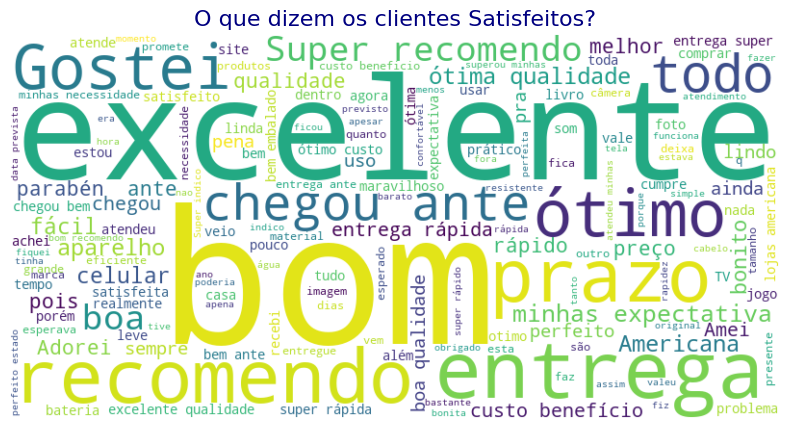

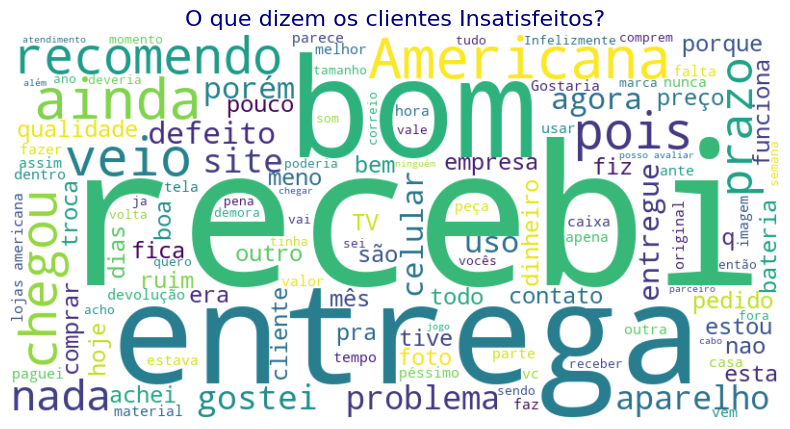

In [21]:
custom_stopwords = ['de', 'a','dia','poi', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para', 'é', 'com', 'não', 'uma', 'os', 'no', 'se', 'na', 'por', 'mais', 'as', 'dos', 'como', 'mas', 'foi', 'ao', 'ele', 'das', 'tem', 'à', 'seu', 'sua', 'ou', 'ser', 'quando', 'muito', 'nos', 'já', 'está', 'eu', 'também', 'só', 'pelo', 'pela', 'até', 'isso', 'ela', 'entre', 'depois', 'sem', 'mesmo', 'aos', 'ter', 'seus', 'quem', 'nas', 'me', 'esse', 'eles', 'você', 'essa', 'num', 'nem', 'suas', 'meu', 'às', 'minha', 'têm', 'numa', 'pelos', 'elas', 'havia', 'seja', 'qual', 'será', 'nós', 'tenho', 'lhe', 'deles', 'essas', 'esses', 'pelas', 'este', 'fosse', 'dele', 'produto', 'loja', 'compra', 'comprei']

def plot_wordcloud(text, title):
    
    wordcloud = WordCloud(width=800, height=400, 
                          background_color='white', 
                          stopwords=custom_stopwords,
                          min_font_size=10).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, size=16, color='navy')
    plt.show()

print("Gerando visualizações...")

texto_pos = " ".join(df[df['sentimento'] == 1]['review_text'])
texto_neg = " ".join(df[df['sentimento'] == 0]['review_text'])

plot_wordcloud(texto_pos, "O que dizem os clientes Satisfeitos?")
plot_wordcloud(texto_neg, "O que dizem os clientes Insatisfeitos?")